In [ ]:
import numpy as np
import pandas as pd

# Original dataset

In [ ]:
df = pd.read_csv("routes.csv")

In [ ]:
df.iloc[:10]

,airline,airline ID,source airport,source airport id,destination apirport,destination airport id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
5,2B,410,DME,4029,KZN,2990,NaN,0,CR2
6,2B,410,DME,4029,NBC,6969,NaN,0,CR2
7,2B,410,DME,4029,TGK,\N,NaN,0,CR2
8,2B,410,DME,4029,UUA,6160,NaN,0,CR2
9,2B,410,EGO,6156,KGD,2952,NaN,0,CR2


For some airports (eg: TGK) there is no id but only "\N", we need to delete lines containing "\N".

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   airline                  67663 non-null  object
 1   airline ID               67663 non-null  object
 2    source airport          67663 non-null  object
 3    source airport id       67663 non-null  object
 4    destination apirport    67663 non-null  object
 5    destination airport id  67663 non-null  object
 6    codeshare               14597 non-null  object
 7    stops                   67663 non-null  int64 
 8    equipment               67645 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.6+ MB


# Dealing with NA values

In [ ]:
df_without_NA_ids = df[~(df[" source airport id"].str.contains("\\\\N")) & ~(df[" destination airport id"].str.contains("\\\\N"))]

In [ ]:
df_without_NA_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67240 entries, 0 to 67662
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   airline                  67240 non-null  object
 1   airline ID               67240 non-null  object
 2    source airport          67240 non-null  object
 3    source airport id       67240 non-null  object
 4    destination apirport    67240 non-null  object
 5    destination airport id  67240 non-null  object
 6    codeshare               14565 non-null  object
 7    stops                   67240 non-null  int64 
 8    equipment               67222 non-null  object
dtypes: int64(1), object(8)
memory usage: 5.1+ MB


423 lines were deleted.

In [ ]:
df_without_NA_ids = df_without_NA_ids[df_without_NA_ids[' stops'] == 0]

In [ ]:
df_without_NA_ids.head()

,airline,airline ID,source airport,source airport id,destination apirport,destination airport id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


# Build a dataframe to create the undirected & weighted graph

In [ ]:
sources_airport = df_without_NA_ids[" source airport"].to_list()
sources_airport_id = df_without_NA_ids[" source airport id"].to_list()
destination_airport = df_without_NA_ids[" destination apirport"].to_list()
destination_airport_id = df_without_NA_ids[" destination airport id"].to_list()

In [ ]:
sources_airport[:5],sources_airport_id[:5] 

(['AER', 'ASF', 'ASF', 'CEK', 'CEK'], ['2965', '2966', '2966', '2968', '2968'])

In [ ]:
len(list(set(sources_airport))) == len(list(set(sources_airport_id)))

True

In [ ]:
len(list(set(destination_airport))) == len(list(set(destination_airport_id)))

True

There is the same number (3315) of unique 'source airport' and unique 'source airport id' so we can only keep the 'source airport' as an id. Same for the destination but the number is higher (3321).

The goal is to create a graph where the nodes are airports and edges are the number of flights between these two.

In [ ]:
df_without_NA_ids.shape

(67229, 9)

Df aggregated by source and destination airport

In [ ]:
df_agg = df_without_NA_ids.groupby([' source airport',' destination apirport']).size().to_frame('nb_trips').reset_index().sort_values('nb_trips',ascending = False)


In [ ]:
df_agg = df_agg.rename(columns={' source airport': 'source_airport', ' destination apirport': 'destination_airport', 'nb_trips': 'cnt_flights'})


In [ ]:
df_agg

,source_airport,destination_airport,cnt_flights
25048,ORD,ATL,20
2023,ATL,ORD,19
25160,ORD,MSY,13
14491,HKT,BKK,13
5553,CAN,HGH,12
...,...,...,...
18650,LAX,CLE,1
18649,LAX,CLD,1
3748,BLL,PSA,1
18646,LAX,BZE,1


Df final: airport A, airport B and number of flights between them

In [ ]:
# Sort the source and destination airport columns
df_agg[['source_airport', 'destination_airport']] = np.sort(df_agg[['source_airport', 'destination_airport']], axis=1)

# Group the dataframe by source and destination airport and sum the cnt_flights
df_final = df_agg.groupby(['source_airport', 'destination_airport'], as_index=False)['cnt_flights'].sum()

# Drop duplicates
df_final.drop_duplicates(inplace=True)
df_final = df_final.rename(columns={'source_airport': 'airport_A', 'destination_airport': 'airport_B', 'cnt_flights': 'total_flights'})


In [ ]:
df_final.sort_values('total_flights', ascending = False)

,airport_A,airport_B,total_flights
2026,ATL,ORD,39
3488,BKK,HKG,24
2008,ATL,MIA,24
12984,JFK,LHR,24
3489,BKK,HKT,23
...,...,...,...
5321,CCC,SNU,1
5322,CCC,VRA,1
5323,CCC,YHZ,1
1121,ALG,TMR,1


## Create directed network with weights

In [ ]:
import networkx as nx

G = nx.Graph()


In [ ]:
for index, row in df_final.iterrows():
    airport_A = row['airport_A']
    airport_B = row['airport_B']
    total_flights = row['total_flights']
    
    G.add_edge( airport_A, airport_B, weight=total_flights)


In [ ]:
nx.write_graphml(G, 'flights_network.graphml')


# Characteristics of network

In [ ]:
import numpy as np
import networkx as nx

def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    

    prop['min_weight'] = np.min([edge[2]['weight'] for edge in graph.edges(data=True)]) # minimum degree
    prop['max_weight'] =np.max([edge[2]['weight'] for edge in graph.edges(data=True)])# maximum degree
    prop['avg_weight'] = np.mean([edge[2]['weight'] for edge in graph.edges(data=True)]) # average weight of edges
    prop['median_weight'] = np.median([edge[2]['weight'] for edge in graph.edges(data=True)]) # median weight of edges

    # Weighted degrees
    weighted_degrees = {node: sum([edge[2]['weight'] for edge in graph.edges(node, data=True)]) for node in graph.nodes()}
    w_degrees = [degree for node, degree in weighted_degrees.items()] # weighted degree list
    prop['min_w_degree'] = np.min(w_degrees) # minimum weighted degree
    prop['max_w_degree'] = np.max(w_degrees) # maximum weighted degree
    prop['mean_w_degree'] = np.mean(w_degrees) # mean of node weighted degrees
    prop['median_w_degree'] = np.median(w_degrees) # median of node weighted degrees
    
    prop['density'] = nx.density(graph) # density of the graph
    return prop

prop = compute_network_characteristics(graph=G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Min. weight: {}".format(prop['min_weight']))
print("Max. weight {}".format(prop['max_weight']))
print("Mean weight: {}".format(prop['avg_weight']))
print("Median weight: {}".format(prop['median_weight']))
print("Min. weighted degree: {}".format(prop['min_w_degree']))
print("Max. weighted degree: {}".format(prop['max_w_degree']))
print("Mean weighted degree: {}".format(prop['mean_w_degree']))
print("Median weighted degree: {}".format(prop['median_w_degree']))
print("Density: {}".format(prop['density']))


Number of nodes: 3330
Number of edges: 19080
Min. degree: 1
Max. degree: 248
Mean degree: 11.45945945945946
Median degree: 3.0
Min. weight: 1
Max. weight 39
Mean weight: 3.5235324947589097
Median weight: 2.0
Min. weighted degree: 1
Max. weighted degree: 1826
Mean weighted degree: 40.37747747747748
Median weighted degree: 8.0
Density: 0.003442312844535734


In [ ]:
## Top10 airports relatively to number of airports they are connected to
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the nodes by degree in descending order and get the top 10

print("Top 10 airports by degree:")
for node, degree in sorted_degrees:
    print("Airport: {}, Degree: {}".format(node, degree))


Top 10 airports by degree:
Airport: AMS, Degree: 248
Airport: FRA, Degree: 244
Airport: CDG, Degree: 240
Airport: IST, Degree: 234
Airport: ATL, Degree: 217
Airport: PEK, Degree: 207
Airport: ORD, Degree: 206
Airport: MUC, Degree: 192
Airport: DME, Degree: 188
Airport: DFW, Degree: 188


In [ ]:
#### UNWEIGHTED degree distribution

import pandas as pd

degrees = dict(G.degree())
degree_counts = {}
for degree in degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Create a list of tuples (degree, count) sorted by degree value
degree_list = sorted(degree_counts.items())

# Convert the list to a Pandas DataFrame
df = pd.DataFrame(degree_list, columns=["Degree", "Count"])

# Print the DataFrame
df


,Degree,Count
0,1,727
1,2,712
2,3,399
3,4,235
4,5,161
...,...,...
137,217,1
138,234,1
139,240,1
140,244,1


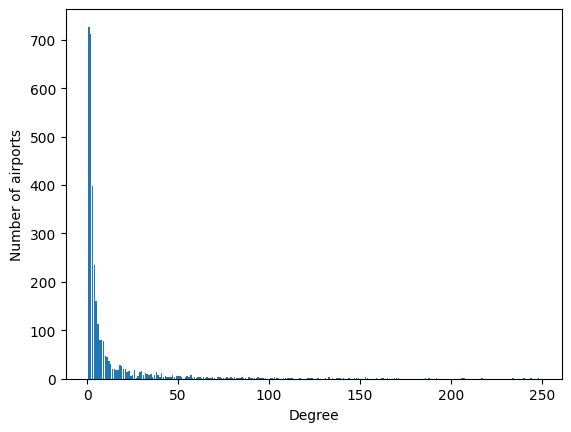

In [ ]:
import matplotlib.pyplot as plt

degrees = dict(G.degree())
degree_counts = {}
for degree in degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

x = list(degree_counts.keys())
y = list(degree_counts.values())

plt.bar(x, y)
plt.xlabel("Degree")
plt.ylabel("Number of airports")
plt.show()


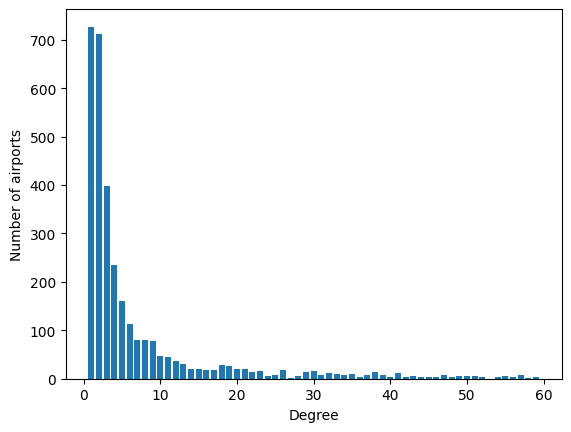

In [ ]:

degrees = dict(G.degree())
degree_counts = {}
for degree in degrees.values():
    if degree < 60:  # only count degrees less than 100
        if degree in degree_counts:
            degree_counts[degree] += 1
        else:
            degree_counts[degree] = 1

x = list(degree_counts.keys())
y = list(degree_counts.values())

plt.bar(x, y)
plt.xlabel("Degree")
plt.ylabel("Number of airports")
plt.show()


In [ ]:
degrees = dict(G.degree())
degree_counts = {"1-4": 0, "5-9": 0, "10-19": 0, "20-49": 0, "50-99": 0, "100+": 0}

for degree in degrees.values():
    if degree <= 4:
        degree_counts["1-4"] += 1
    elif degree <= 9:
        degree_counts["5-9"] += 1
    elif degree <= 19:
        degree_counts["10-19"] += 1
    elif degree <= 49:
        degree_counts["20-49"] += 1
    elif degree <= 99:
        degree_counts["50-99"] += 1
    else:
        degree_counts["100+"] += 1

# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(list(degree_counts.items()), columns=["Degree Range", "Count"])

# Print the DataFrame
df


,Degree Range,Count
0,1-4,2073
1,5-9,511
2,10-19,289
3,20-49,267
4,50-99,126
5,100+,64


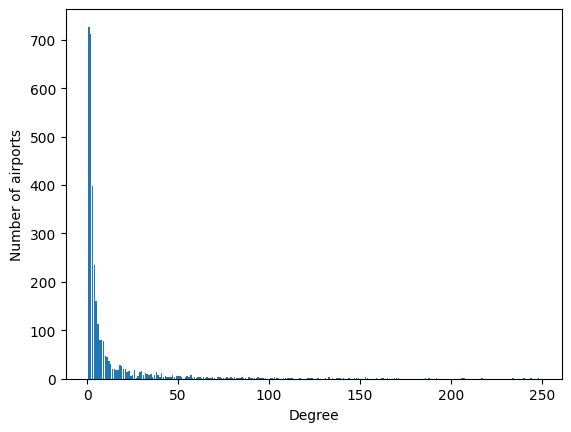

In [ ]:
## WEIGHTED degree distribution

degrees = dict(G.degree())
degree_counts = {}
for degree in degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

x = list(degree_counts.keys())
y = list(degree_counts.values())

plt.bar(x, y)
plt.xlabel("Degree")
plt.ylabel("Number of airports")
plt.show()


In [ ]:
# quantiles
degrees = dict(G.degree())
degree_values = list(degrees.values())
degree_values.sort()

total_degrees = len(degree_values)

# Compute decile indices
decile_indices = [round(total_degrees*i/10) for i in range(1, 10)]

# Get the degrees at each decile index
decile_degrees = [degree_values[index] for index in decile_indices]

# Print deciles and corresponding degrees
for i, degree in enumerate(decile_degrees):
    print(f"Degree at decile {i+1}: {degree}")


Degree at decile 1: 1
Degree at decile 2: 1
Degree at decile 3: 2
Degree at decile 4: 2
Degree at decile 5: 3
Degree at decile 6: 4
Degree at decile 7: 6
Degree at decile 8: 11
Degree at decile 9: 30


In [ ]:
weighted_degrees = {node: sum([edge[2]['weight'] for edge in G.edges(node, data=True)]) for node in G.nodes()}


In [ ]:
sorted_nodes = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes with highest weighted degree:")
for node, degree in sorted_nodes[:-10]:
    print(f"{node} - {degree}")


Top 10 nodes with highest weighted degree:
ATL - 1826
ORD - 1108
PEK - 1069
LHR - 1047
CDG - 1041
LAX - 990
FRA - 990
DFW - 936
JFK - 911
AMS - 903
PVG - 825
SIN - 814
BCN - 783
ICN - 740
DEN - 735
MIA - 734
MUC - 728
IST - 715
LGW - 708
HKG - 708
DXB - 702
CAN - 672
FCO - 661
MAD - 661
BKK - 654
CTU - 647
DME - 646
YYZ - 636
BRU - 630
MAN - 627
VIE - 616
CLT - 600
PHL - 576
NRT - 575
DUS - 570
XIY - 563
PMI - 548
KMG - 545
CKG - 540
TPE - 527
DEL - 517
KUL - 510
PHX - 508
HGH - 506
EWR - 505
SFO - 499
LAS - 498
ZRH - 494
IAH - 485
MEX - 483
AUH - 473
MCO - 470
SZX - 467
XMN - 466
CPH - 457
BOM - 442
ARN - 438
LIS - 435
DTW - 433
MSP - 430
BOS - 422
TXL - 418
DUB - 414
SHA - 411
AGP - 410
SYD - 410
SEA - 403
ATH - 403
ORY - 402
SVO - 397
DCA - 388
GRU - 387
IAD - 386
MXP - 386
MNL - 386
CSX - 377
TAO - 376
DOH - 375
FLL - 374
WUH - 374
JED - 372
YUL - 371
LED - 367
CGK - 367
OSL - 363
PRG - 361
CGO - 348
STN - 343
NKG - 330
GVA - 329
HAM - 321
JNB - 320
HEL - 320
TFS - 318
LGA - 316
HN

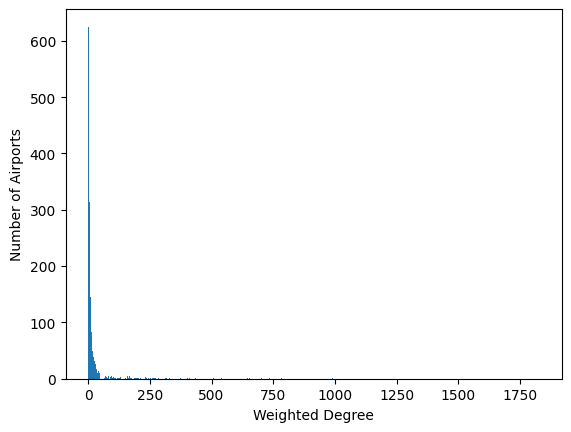

In [ ]:
### histogram of weighted degree
import matplotlib.pyplot as plt

weighted_degrees = {node: sum([edge[2]['weight'] for edge in G.edges(node, data=True)]) for node in G.nodes()}

degree_counts = {}
for degree in weighted_degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

x = list(degree_counts.keys())
y = list(degree_counts.values())

plt.bar(x, y)
plt.xlabel("Weighted Degree")
plt.ylabel("Number of Airports")
plt.show()


In [ ]:
import pandas as pd

weighted_degrees = {node: sum([edge[2]['weight'] for edge in G.edges(node, data=True)]) for node in G.nodes()}
degree_counts = {"1-4": 0,"5-9": 0, "10-29": 0, "30-49": 0, "50-99": 0, "100-499": 0, "500-999": 0,"1000+": 0}

for degree in weighted_degrees.values():
    if degree <= 4:
        degree_counts["1-4"] += 1
    elif degree <= 9:
        degree_counts["5-9"] += 1
    elif degree <= 29:
        degree_counts["10-29"] += 1
    elif degree <= 49:
        degree_counts["30-49"] += 1
    elif degree <= 99:
        degree_counts["50-99"] += 1
    elif degree <= 499:
        degree_counts["100-499"] += 1
    elif degree <= 999:
        degree_counts["500-999"] += 1
    else:
        degree_counts["1000+"] += 1

# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(list(degree_counts.items()), columns=["Weighted Degree Range", "Count"])

# Print the DataFrame
df


,Weighted Degree Range,Count
0,1-4,1217
1,5-9,622
2,10-29,757
3,30-49,208
4,50-99,212
5,100-499,269
6,500-999,40
7,1000+,5


In [ ]:
weighted_degrees = {node: sum([edge[2]['weight'] for edge in G.edges(node, data=True)]) for node in G.nodes()}
degree_values = list(weighted_degrees.values())
degree_values.sort()

total_degrees = len(degree_values)

# Compute decile indices
decile_indices = [round(total_degrees*i/10) for i in range(1, 10)]

# Get the degrees at each decile index
decile_degrees = [degree_values[index] for index in decile_indices]

# Print deciles and corresponding degrees
for i, degree in enumerate(decile_degrees):
    print(f"Weighted degree at decile {i+1}: {degree}")


Weighted degree at decile 1: 2
Weighted degree at decile 2: 3
Weighted degree at decile 3: 4
Weighted degree at decile 4: 6
Weighted degree at decile 5: 8
Weighted degree at decile 6: 11
Weighted degree at decile 7: 18
Weighted degree at decile 8: 34
Weighted degree at decile 9: 92


# Components of network

In [ ]:
import networkx as nx

# Get connected components and their sizes
components = sorted(nx.connected_components(G), key=len, reverse=True)
sizes = [len(c) for c in components]

# Print the number of nodes in each component
for i, c in enumerate(components):
    print(f"Component {i+1}: {len(c)} nodes")


Component 1: 3304 nodes
Component 2: 10 nodes
Component 3: 4 nodes
Component 4: 4 nodes
Component 5: 4 nodes
Component 6: 2 nodes
Component 7: 2 nodes


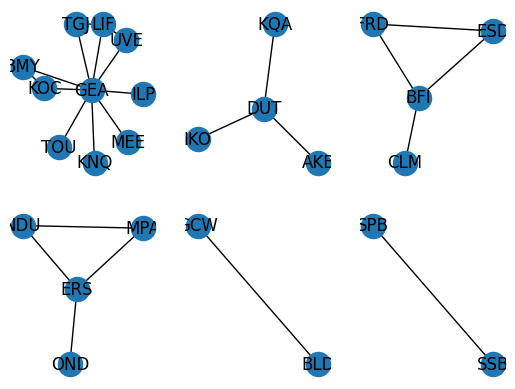

In [ ]:
# Get connected components and their sizes
components = sorted(nx.connected_components(G), key=len, reverse=True)

# Draw components 2 to 7
for i, c in enumerate(components[1:]):
    subgraph = G.subgraph(c)
    plt.subplot(2, 3, i+1)
    nx.draw(subgraph, with_labels=True)

# Show the plot
plt.show()


1 component contains airports from Nouméa island, another 4 airports from Namibia, another f4 four Alska, another 2 in grand canyon region, 2 in the virgin islands, and 4 components in Wahshinghton region. For most of them, it is isolated areas with one airport more central that relies cities between each other

# Centralities measures

Function to sort centralities

In [ ]:
def sort_centrality (centralities):
  sorted_values = sorted(centralities.items(), key=lambda x: x[1], reverse=True)

  for node, centrality in sorted_values:
    print(f"Node {node}: centrality = {centrality}")


Degree centrality

In [ ]:
def degree_centrality(graph):
  
    degree_centrality = {}

    m = np.mean([degree for _, degree in nx.degree(G)]) 
    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node) / m
    
    return degree_centrality

In [ ]:
sort_centrality(degree_centrality(G))

Node AMS: centrality = 21.641509433962263
Node FRA: centrality = 21.29245283018868
Node CDG: centrality = 20.943396226415093
Node IST: centrality = 20.419811320754718
Node ATL: centrality = 18.93632075471698
Node PEK: centrality = 18.06367924528302
Node ORD: centrality = 17.97641509433962
Node MUC: centrality = 16.754716981132074
Node DME: centrality = 16.40566037735849
Node DFW: centrality = 16.40566037735849
Node DXB: centrality = 16.2311320754717
Node LHR: centrality = 14.922169811320755
Node DEN: centrality = 14.834905660377359
Node IAH: centrality = 14.747641509433961
Node LGW: centrality = 14.398584905660377
Node BCN: centrality = 14.224056603773585
Node JFK: centrality = 14.13679245283019
Node FCO: centrality = 14.13679245283019
Node MAD: centrality = 13.875
Node PVG: centrality = 13.43867924528302
Node STN: centrality = 13.351415094339622
Node BRU: centrality = 13.351415094339622
Node EWR: centrality = 13.351415094339622
Node LAX: centrality = 13.002358490566037
Node CAN: centr

In [ ]:
def weight_degree_centrality(graph):

    degree_centrality = {}
    
    m = np.mean([degree for _, degree in graph.degree(weight='weight')]) 
    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node, weight='weight') / m
    return degree_centrality
   

In [ ]:
weighted_degree_centrality =weight_degree_centrality(G)

In [ ]:
sort_centrality(weighted_degree_centrality)

Node ATL: centrality = 45.222894881673085
Node ORD: centrality = 27.440836543753438
Node PEK: centrality = 26.474958723170058
Node LHR: centrality = 25.930104567969178
Node CDG: centrality = 25.78150798018712
Node LAX: centrality = 24.518436984039624
Node FRA: centrality = 24.518436984039624
Node DFW: centrality = 23.1810676940011
Node JFK: centrality = 22.56191524490919
Node AMS: centrality = 22.36378646119978
Node PVG: centrality = 20.43203082003302
Node SIN: centrality = 20.15960374243258
Node BCN: centrality = 19.39185470555861
Node ICN: centrality = 18.326912493120528
Node DEN: centrality = 18.203082003302146
Node MIA: centrality = 18.17831590533847
Node MUC: centrality = 18.02971931755641
Node IST: centrality = 17.707760044028618
Node LGW: centrality = 17.534397358282884
Node HKG: centrality = 17.534397358282884
Node DXB: centrality = 17.385800770500826
Node CAN: centrality = 16.642817831590534
Node FCO: centrality = 16.370390753990094
Node MAD: centrality = 16.370390753990094
No

Using degree centrality measure, we notice that the top5 most important airports are in Atlanta, Chicago, Pékin, Londres & Paris cities. We also notice that the ranking changes using weights for number of flights. This approach is more accurate here and we'll always use weights to compute centralities measures. 

Closeness centrality

In [ ]:
def weighted_closeness_centrality(graph):
  
    closeness_centrality = {}
    for node in graph.nodes():
        closeness_centrality[node] = nx.closeness_centrality(graph, node, distance='total_flights')
    return closeness_centrality


In [ ]:
closeness_centrality = (weighted_closeness_centrality(G))

In [ ]:
sort_centrality(closeness_centrality )

Node FRA: centrality = 0.40409408927042884
Node CDG: centrality = 0.40142124742567104
Node LHR: centrality = 0.3991235006677844
Node AMS: centrality = 0.3952246821012033
Node DXB: centrality = 0.3942262798006951
Node LAX: centrality = 0.39046861241310354
Node JFK: centrality = 0.3884322702362425
Node YYZ: centrality = 0.3839722394825048
Node IST: centrality = 0.3816914819453969
Node ORD: centrality = 0.3815137443519416
Node PEK: centrality = 0.3804066237937525
Node MUC: centrality = 0.38027420097275216
Node FCO: centrality = 0.377906257378134
Node NRT: centrality = 0.3774709817994907
Node EWR: centrality = 0.37694997285290754
Node ICN: centrality = 0.37608481340178773
Node DOH: centrality = 0.3756537212268659
Node ZRH: centrality = 0.3738112312060201
Node MAD: centrality = 0.3728755335058799
Node IAH: centrality = 0.3727907023072663
Node HKG: centrality = 0.3722825245919775
Node IAD: centrality = 0.37030543095855123
Node DFW: centrality = 0.3689712974536341
Node ATL: centrality = 0.368

Using closeness centrality measure, we notice that the top5 most important airports are in Franckfurt, Paris, Londres, Amsterdam et Dubaï, which means that they are more central in the sense that they are more easily reachable from all other airports. Atlanta, Chicago & Pékin are the top3 for degree centrality, which focus on the number of direct connections, we can see that they're not in the top5 of closeness centrality that looks at the overall position of a node in the network and how easily it can access other nodes.

Betwenness centrality

In [ ]:
def weighted_betwenness_centrality(graph):
    betweenness_centrality = {}
    
    for node in graph.nodes():
        betweenness_centrality[node] = nx.betweenness_centrality(graph, node, weight='total_flights')
    return betweenness_centrality


In [ ]:
betweenness_centrality = nx.betweenness_centrality(G, weight='total_flights')

In [ ]:
sort_centrality(betweenness_centrality)

Node ANC: centrality = 0.07394416844980096
Node LAX: centrality = 0.06516904583743961
Node CDG: centrality = 0.06250529820404557
Node DXB: centrality = 0.05577466234380082
Node FRA: centrality = 0.05191619606084191
Node AMS: centrality = 0.05021645527358144
Node PEK: centrality = 0.049581810463643905
Node ORD: centrality = 0.04898548908024117
Node SEA: centrality = 0.04700095832860758
Node YYZ: centrality = 0.0433808721575994
Node IST: centrality = 0.041403950419182885
Node GRU: centrality = 0.04040330045450328
Node LHR: centrality = 0.03685166492767212
Node NRT: centrality = 0.035455708377846
Node SYD: centrality = 0.033647278190740045
Node BNE: centrality = 0.03176272729380764
Node SIN: centrality = 0.031079185242885738
Node ATL: centrality = 0.02966804760516961
Node DFW: centrality = 0.029501956863463106
Node DME: centrality = 0.029074222153206247
Node HKG: centrality = 0.02794695822011178
Node YUL: centrality = 0.02750093536104322
Node ICN: centrality = 0.027210578336681848
Node DE

Using betweenness centrality measure, we notice that the top5 most important airport is in Alaska, in Anchrorage city. This airport is indeed the hub for Alaska Airlines. It is also the 4th largest airport in the world in terms of commercial traffic after Memphis, Hong Kong and Tokyo).
The 4 other most important airports are Los angeles, Paris, Dubai and Frankfut, which means that they are more central in the sense that they are more easily reachable from all other airports

Closeness centrality measures how quickly a node can access all other nodes in the network. Specifically, it is defined as the reciprocal of the average shortest path distance from the node to all other nodes in the network. Nodes with high closeness centrality are those that can reach other nodes quickly, and are often important for information flow and spreading.

Betweenness centrality, on the other hand, measures how often a node appears on the shortest path between other pairs of nodes in the network. It is defined as the fraction of shortest paths between all pairs of nodes that pass through the node in question. Nodes with high betweenness centrality are those that are important for maintaining connectivity and facilitating communication between different parts of the network.

In summary, closeness centrality measures how fast a node can reach other nodes, while betweenness centrality measures how important a node is for connecting different parts of the network.

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G, weight='total_flights')
sort_centrality(eigenvector_centrality)

Node AMS: centrality = 0.16791847410082034
Node FRA: centrality = 0.16642030081947376
Node CDG: centrality = 0.15948508070405804
Node MUC: centrality = 0.1485668835565022
Node FCO: centrality = 0.13636501492985625
Node LHR: centrality = 0.13595447472504085
Node IST: centrality = 0.1292581752723354
Node BCN: centrality = 0.12818030074618372
Node ZRH: centrality = 0.1260382820769736
Node MAD: centrality = 0.12301346118518763
Node BRU: centrality = 0.12298353667348445
Node DUB: centrality = 0.11606972847619429
Node DUS: centrality = 0.11513014933403956
Node MAN: centrality = 0.11482180294390247
Node LGW: centrality = 0.1145675098465749
Node VIE: centrality = 0.114049336506386
Node CPH: centrality = 0.10942969467465218
Node JFK: centrality = 0.10657470628777525
Node MXP: centrality = 0.1054814555985122
Node DXB: centrality = 0.10351957478969323
Node GVA: centrality = 0.10032683240888281
Node TXL: centrality = 0.09795624413884667
Node SVO: centrality = 0.09555414649834938
Node ARN: centrali

Amsterdam, Frankfurt, Paris, Munich, Roma are the top5 airports

Final ranking using median of centrality measures

In [ ]:
# Convert the centrality measures to dataframes
df_degree = pd.DataFrame.from_dict(weighted_degree_centrality, orient='index', columns=['degree_centrality'])
df_closeness = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['closeness_centrality'])
df_betwenness = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betwenness_centrality'])
#df_harmonic = pd.DataFrame.from_dict(harmonic_centrality, orient='index', columns=['harmonic_centrality'])
df_eigenvector = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['eigenvector_centrality'])


# Add a rank column for each centrality measure
df_degree['degree_rank'] = df_degree['degree_centrality'].rank(ascending=False)
df_closeness['closeness_rank'] = df_closeness['closeness_centrality'].rank(ascending=False)
df_betwenness['betwenness_rank'] = df_betwenness['betwenness_centrality'].rank(ascending=False)
#df_harmonic['harmonic_rank'] = df_harmonic['harmonic_centrality'].rank(ascending=False)
df_eigenvector['eigenvector_rank'] = df_eigenvector['eigenvector_centrality'].rank(ascending=False)


# Calculate the median and mean of each ranking
df_sumup  = pd.concat([df_degree, df_closeness, df_betwenness, df_eigenvector], axis=1)


In [ ]:
df_ranking = df_sumup.drop(columns = ['degree_centrality', 'closeness_centrality','betwenness_centrality', 'eigenvector_centrality'])

df_ranking['mean_rank'] = df_ranking.iloc[:, 0:3].mean(axis=1)
df_ranking['median_rank'] = df_ranking.iloc[:, 0:3].median(axis=1)


# Sort the dataframe by the average ranking
#df_ranking = 


In [ ]:
df_ranking.sort_values(by=['median_rank'], ascending=True).head(50)

,degree_rank,closeness_rank,betwenness_rank,eigenvector_rank,mean_rank,median_rank
CDG,5.0,2.0,3.0,3.0,3.333333,3.0
LHR,4.0,3.0,13.0,6.0,6.666667,4.0
FRA,6.5,1.0,5.0,2.0,4.166667,5.0
DXB,21.0,5.0,4.0,20.0,10.000000,5.0
LAX,6.5,6.0,2.0,49.0,4.833333,6.0
AMS,10.0,4.0,6.0,1.0,6.666667,6.0
PEK,3.0,11.0,7.0,34.0,7.000000,7.0
ORD,2.0,10.0,8.0,28.0,6.666667,8.0
JFK,9.0,7.0,25.0,18.0,13.666667,9.0
YYZ,28.0,8.0,10.0,29.0,15.333333,10.0


when using median rank on all centrality measures, CDG airport is the most central airport, then come airports in London, Frankfurt, Dubaï and Los Angeles cities.